In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
db_path = 'data/processed/NVDA_proc.sqlite'
conn = sqlite3.connect(db_path)

# List tables in the sqlite file
tables = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';",
    conn
)

if tables.empty:
    conn.close()
    raise ValueError(f'No tables found in {db_path}')

# Prefer a table with "nvda" in its name, otherwise pick the first table
candidates = [n for n in tables['name'].tolist() if 'nvda' in n.lower()]
table_name = candidates[0] if candidates else tables['name'].iloc[0]

print(f'Loading table "{table_name}" from {db_path}')
df_nvda = pd.read_sql_query(f'SELECT * FROM "{table_name}"', conn, parse_dates=True)

print(f'Loaded df_nvda with shape {df_nvda.shape}')
display(df_nvda.tail())

conn.close()

Loading table "NVDA" from data/processed/NVDA_proc.sqlite
Loaded df_nvda with shape (6513, 7)


,Price,Close,High,Low,Open,Volume,Date
6508,2025-11-17,186.60000610351562,189.0,184.32000732421875,185.97000122070312,173628900,2025-11-17 00:00:00
6509,2025-11-18,181.36000061035156,184.8000030517578,179.64999389648438,183.3800048828125,213598900,2025-11-18 00:00:00
6510,2025-11-19,186.52000427246094,187.86000061035156,182.8300018310547,184.7899932861328,247246400,2025-11-19 00:00:00
6511,2025-11-20,180.63999938964844,196.0,179.85000610351562,195.9499969482422,343504800,2025-11-20 00:00:00
6512,2025-11-21,178.8800048828125,184.55999755859375,172.92999267578125,181.24000549316406,346068500,2025-11-21 00:00:00


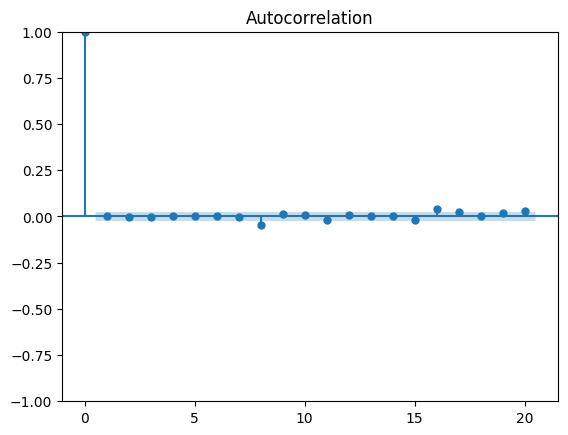

In [ ]:
# Ensure Close is numeric, if needed
df_nvda['Close'] = pd.to_numeric(df_nvda['Close'], errors='coerce')

# 2. Compute log returns on Close only
stock_returns = np.log(df_nvda['Close'] / df_nvda['Close'].shift(1))
stock_returns = stock_returns.dropna()


# 3. Fit ARIMA(0,0,2) on returns
model = ARIMA(stock_returns.values, order=(3, 0, 2))
model = model.fit()

# 4. Plot ACF of residuals
plot_acf(model.resid, lags=20)
plt.show()